## Import Libraries

In [2334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Explore Dataset

In [2335]:
df = pd.read_csv("insurance_data_work.csv")

In [2336]:
print(df.head())

   index  PatientID   age gender   bmi  bloodpressure diabetic  children  \
0      0          1  39.0   male  23.2             91      Yes         0   
1      1          2  24.0   male  30.1             87       No         0   
2      2          3   NaN   male  33.3             82      Yes         0   
3      3          4   NaN   male  33.7             80       No         0   
4      4          5   NaN   male  34.1            100       No         0   

  smoker     region    claim  
0     No  southeast  1121.87  
1     No  southeast  1131.51  
2     No  southeast  1135.94  
3     No  northwest  1136.40  
4     No  northwest  1137.01  


In [2337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


In [2338]:
df.isnull().sum()

index            0
PatientID        0
age              5
gender           0
bmi              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

In [2339]:
df.shape

(1340, 11)

In [2340]:
df.columns

Index(['index', 'PatientID', 'age', 'gender', 'bmi', 'bloodpressure',
       'diabetic', 'children', 'smoker', 'region', 'claim'],
      dtype='object')

## Data Cleaning

In [2341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1340 non-null   int64  
 1   PatientID      1340 non-null   int64  
 2   age            1335 non-null   float64
 3   gender         1340 non-null   object 
 4   bmi            1340 non-null   float64
 5   bloodpressure  1340 non-null   int64  
 6   diabetic       1340 non-null   object 
 7   children       1340 non-null   int64  
 8   smoker         1340 non-null   object 
 9   region         1337 non-null   object 
 10  claim          1340 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 115.3+ KB


In [2342]:
df = df.dropna()

In [2343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          1332 non-null   int64  
 1   PatientID      1332 non-null   int64  
 2   age            1332 non-null   float64
 3   gender         1332 non-null   object 
 4   bmi            1332 non-null   float64
 5   bloodpressure  1332 non-null   int64  
 6   diabetic       1332 non-null   object 
 7   children       1332 non-null   int64  
 8   smoker         1332 non-null   object 
 9   region         1332 non-null   object 
 10  claim          1332 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 124.9+ KB


In [2344]:
df = df.drop(['index', 'PatientID'], axis=1)

In [2345]:
df.info()
dataBackup = df

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1332 non-null   float64
 1   gender         1332 non-null   object 
 2   bmi            1332 non-null   float64
 3   bloodpressure  1332 non-null   int64  
 4   diabetic       1332 non-null   object 
 5   children       1332 non-null   int64  
 6   smoker         1332 non-null   object 
 7   region         1332 non-null   object 
 8   claim          1332 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 104.1+ KB


## Exploratory Data Analysis (EDA)

In [2346]:
print(df.describe())

               age          bmi  bloodpressure     children         claim
count  1332.000000  1332.000000    1332.000000  1332.000000   1332.000000
mean     38.086336    30.658333      94.189189     1.099850  13325.246426
std      11.112804     6.118967      11.445173     1.205958  12109.620712
min      18.000000    16.000000      80.000000     0.000000   1121.870000
25%      29.000000    26.200000      86.000000     0.000000   4760.157500
50%      38.000000    30.350000      92.000000     1.000000   9412.965000
75%      47.000000    34.725000      99.000000     2.000000  16781.327500
max      60.000000    53.100000     140.000000     5.000000  63770.430000


In [2347]:
print(df.describe(include=['O']))

       gender diabetic smoker     region
count    1332     1332   1332       1332
unique      2        2      2          4
top      male       No     No  southeast
freq      670      695   1058        442


Text(0.5, 1.0, 'Age Distribution')

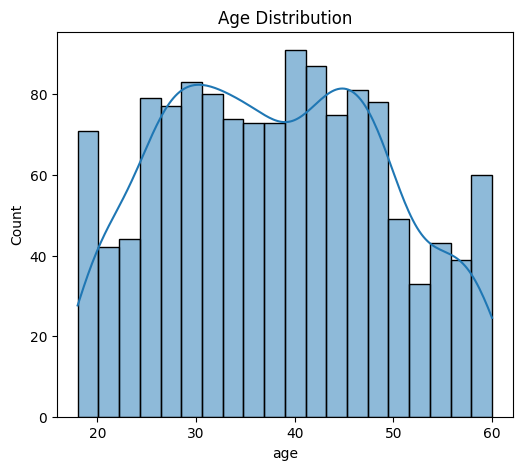

In [2348]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')


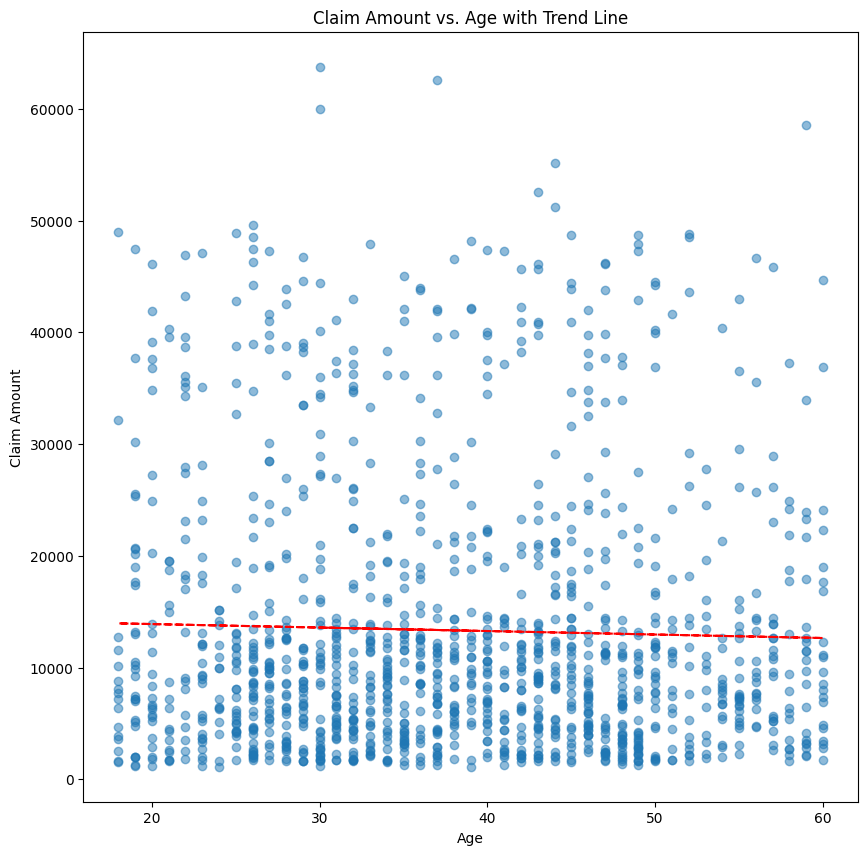

In [2349]:
plt.figure(figsize=(10, 10))

# Scatter plot
plt.scatter(df['age'], df['claim'], alpha=0.5)

# Add a trend line
z = np.polyfit(df['age'], df['claim'], 1)
p = np.poly1d(z)
plt.plot(df['age'], p(df['age']), "r--")

plt.title('Claim Amount vs. Age with Trend Line')
plt.xlabel('Age')
plt.ylabel('Claim Amount')
plt.show()

Text(0.5, 1.0, 'BMI Distribution')

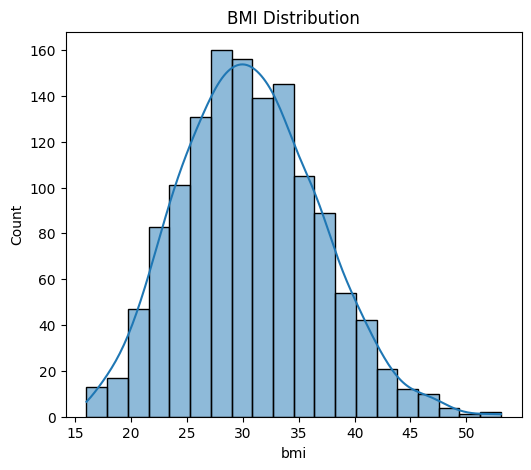

In [2350]:
plt.figure(figsize=(20, 5))

# BMI Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['bmi'], bins=20, kde=True)
plt.title('BMI Distribution')

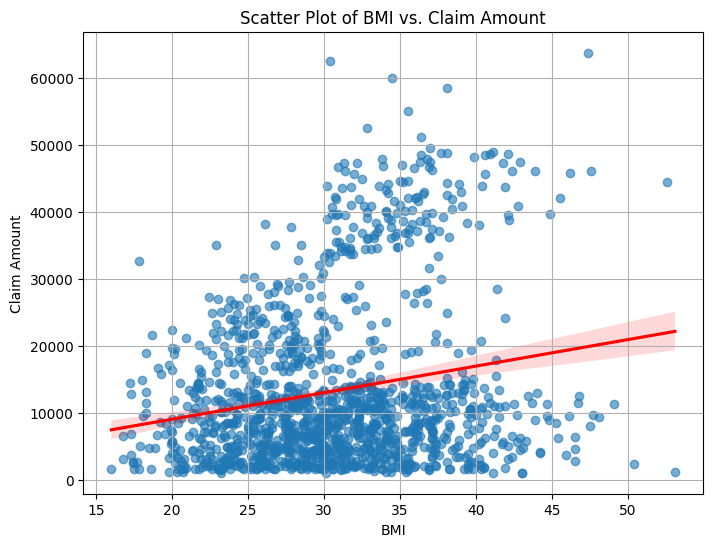

In [2351]:
plt.figure(figsize=(8, 6))
sns.regplot(x='bmi', y='claim', data=df, scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Scatter Plot of BMI vs. Claim Amount')
plt.xlabel('BMI')
plt.ylabel('Claim Amount')
plt.grid()
plt.show()

In [2352]:
##Upward trendline, so patients with higher bmi may have more health issues, potentially leading to increased medical costs and claims.

Text(0.5, 1.0, 'Claim Amount Distribution')

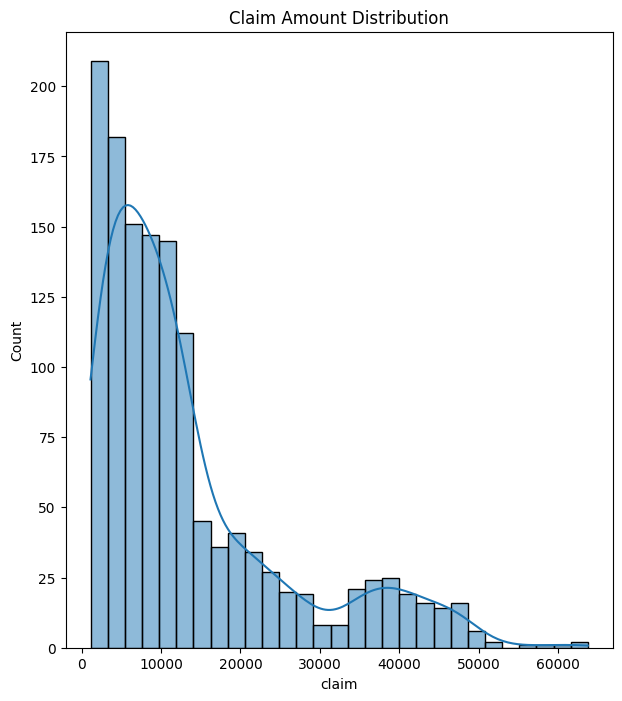

In [2353]:
plt.figure(figsize=(24, 8))

# Claim Amount Distribution
plt.subplot(1, 3, 3)
sns.histplot(df['claim'], kde=True)
plt.title('Claim Amount Distribution')


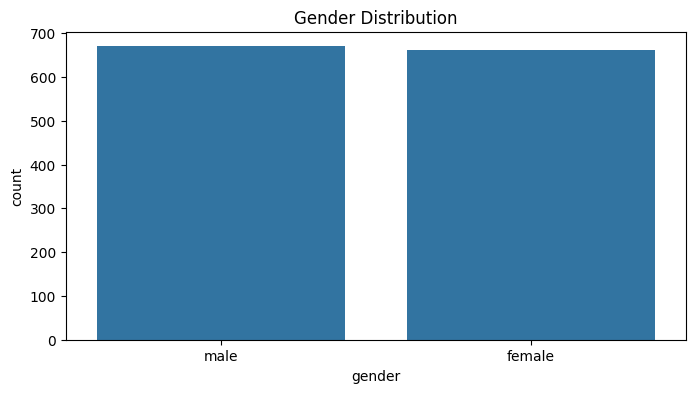

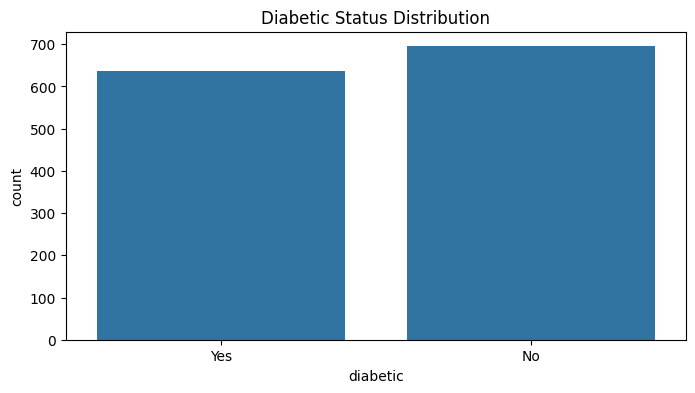

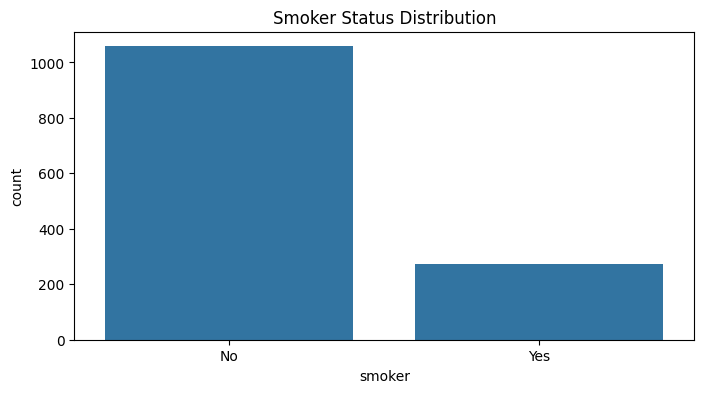

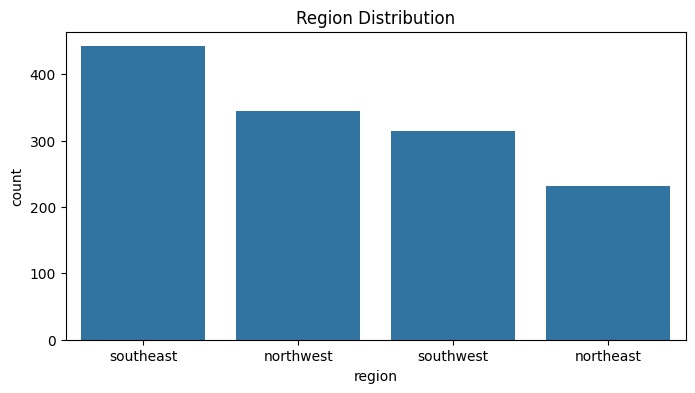

In [2354]:
# Gender Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

# Diabetic Status Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='diabetic', data=df)
plt.title('Diabetic Status Distribution')
plt.show()

# Smoker Status Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='smoker', data=df)
plt.title('Smoker Status Distribution')
plt.show()

# Region Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='region', data=df)
plt.title('Region Distribution')
plt.show()

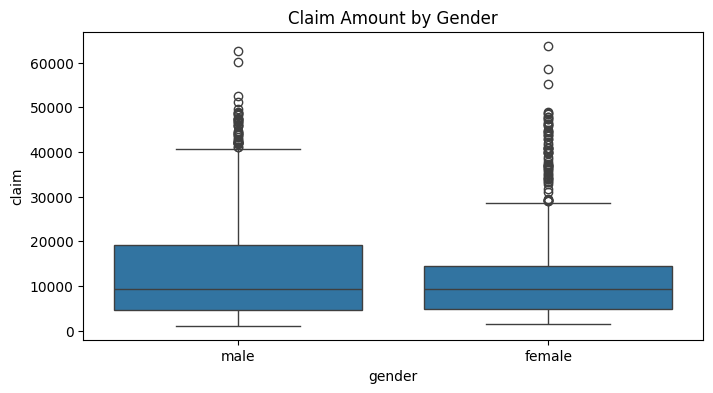

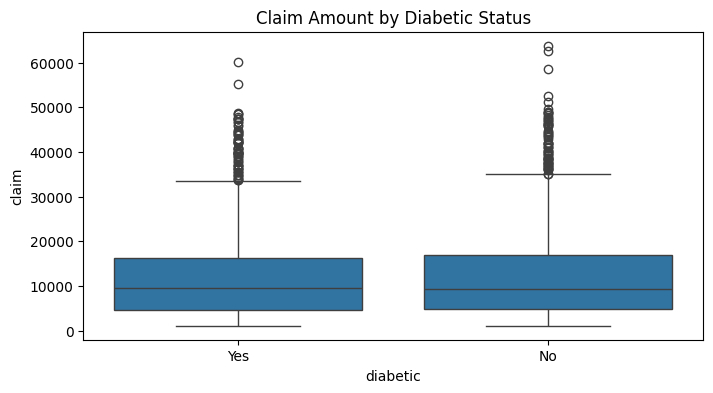

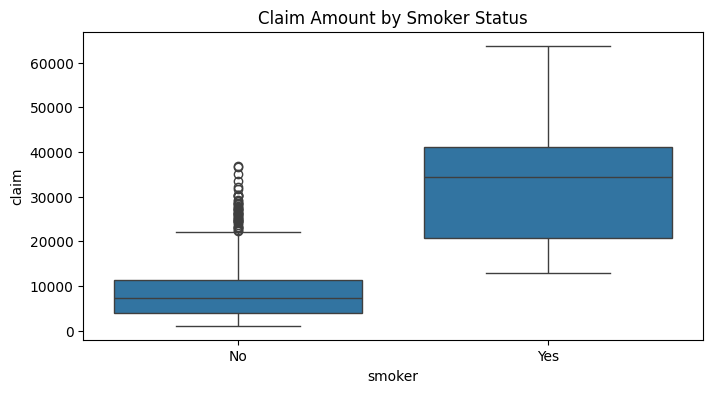

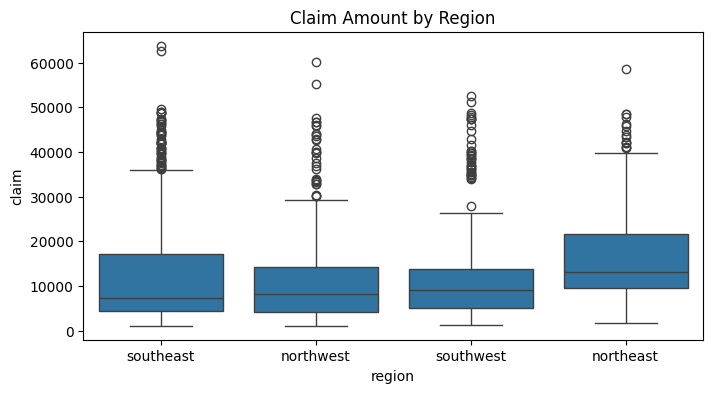

In [2355]:
# Boxplot for Claim by Gender
plt.figure(figsize=(8, 4))
sns.boxplot(x='gender', y='claim', data=df)
plt.title('Claim Amount by Gender')
plt.show()

# Boxplot for Claim by Diabetic Status
plt.figure(figsize=(8, 4))
sns.boxplot(x='diabetic', y='claim', data=df)
plt.title('Claim Amount by Diabetic Status')
plt.show()

# Boxplot for Claim by Smoker Status
plt.figure(figsize=(8, 4))
sns.boxplot(x='smoker', y='claim', data=df)
plt.title('Claim Amount by Smoker Status')
plt.show()

# Boxplot for Claim by Region
plt.figure(figsize=(8, 4))
sns.boxplot(x='region', y='claim', data=df)
plt.title('Claim Amount by Region')
plt.show()

## Feature Engineering

In [2356]:
# Creating age group bins
bins = [0, 30, 50, 100]
labels = ['Young Adult', 'Middle-Aged', 'Senior']
df['agegroup'] = pd.cut(df['age'], bins=bins, labels=labels)

In [2357]:
# BMI group classification (based on standard BMI categories)
# bmi_bins = [0, 18.5, 24.9, 29.9, 100]
# bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

bmi_bins = [0, 18.5, 24.9, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight']
df['bmigroup'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

In [2358]:
# Log-transforming claim amounts to normalize the distribution
df['Log_Claims'] = np.log(df['claim'] + 1)

### Laebl Encoding

In [2359]:
print(df['gender'].unique())
print(df['diabetic'].unique())
print(df['smoker'].unique())
print(df['region'].unique())


['male' 'female']
['Yes' 'No']
['No' 'Yes']
['southeast' 'northwest' 'southwest' 'northeast']


In [2360]:
df['gender'] = df['gender'].map({'male': 0, 'female': 1})
df['diabetic'] = df['diabetic'].map({'Yes': 0, 'No': 1})
df['smoker'] = df['smoker'].map({'Yes': 0, 'No': 1})
df['region'] = df['region'].map({'southeast': 0.66, 'northwest': 0, 'southwest': 1, 'northeast': 0.33})

In [2361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            1332 non-null   float64 
 1   gender         1332 non-null   int64   
 2   bmi            1332 non-null   float64 
 3   bloodpressure  1332 non-null   int64   
 4   diabetic       1332 non-null   int64   
 5   children       1332 non-null   int64   
 6   smoker         1332 non-null   int64   
 7   region         1332 non-null   float64 
 8   claim          1332 non-null   float64 
 9   agegroup       1332 non-null   category
 10  bmigroup       1332 non-null   category
 11  Log_Claims     1332 non-null   float64 
dtypes: category(2), float64(5), int64(5)
memory usage: 117.3 KB


In [2362]:
# One-hot encoding Age_group and BMI_group
df = pd.get_dummies(df, columns=['agegroup', 'bmigroup'], drop_first=True)
# df = pd.get_dummies(df, columns=['bmigroup'], drop_first=True)

df.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim,Log_Claims,agegroup_Middle-Aged,agegroup_Senior,bmigroup_Normal,bmigroup_Overweight
0,39.0,0,23.2,91,0,0,1,0.66,1121.87,7.023643,True,False,True,False
1,24.0,0,30.1,87,1,0,1,0.66,1131.51,7.032192,False,False,False,True
7,19.0,0,41.1,100,1,0,1,0.00,1146.80,7.045602,False,False,False,True
8,20.0,0,43.0,86,1,0,1,0.00,1149.40,7.047865,False,False,False,True
9,30.0,0,53.1,97,1,0,1,0.00,1163.46,7.060013,False,False,False,True


In [2363]:
# Converting boolean columns to integers
for col in df.columns:
    if 'agegroup' in col or 'bmigroup' in col:
        df[col] = df[col].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1332 non-null   float64
 1   gender                1332 non-null   int64  
 2   bmi                   1332 non-null   float64
 3   bloodpressure         1332 non-null   int64  
 4   diabetic              1332 non-null   int64  
 5   children              1332 non-null   int64  
 6   smoker                1332 non-null   int64  
 7   region                1332 non-null   float64
 8   claim                 1332 non-null   float64
 9   Log_Claims            1332 non-null   float64
 10  agegroup_Middle-Aged  1332 non-null   int32  
 11  agegroup_Senior       1332 non-null   int32  
 12  bmigroup_Normal       1332 non-null   int32  
 13  bmigroup_Overweight   1332 non-null   int32  
dtypes: float64(5), int32(4), int64(5)
memory usage: 135.3 KB


In [2364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1332 non-null   float64
 1   gender                1332 non-null   int64  
 2   bmi                   1332 non-null   float64
 3   bloodpressure         1332 non-null   int64  
 4   diabetic              1332 non-null   int64  
 5   children              1332 non-null   int64  
 6   smoker                1332 non-null   int64  
 7   region                1332 non-null   float64
 8   claim                 1332 non-null   float64
 9   Log_Claims            1332 non-null   float64
 10  agegroup_Middle-Aged  1332 non-null   int32  
 11  agegroup_Senior       1332 non-null   int32  
 12  bmigroup_Normal       1332 non-null   int32  
 13  bmigroup_Overweight   1332 non-null   int32  
dtypes: float64(5), int32(4), int64(5)
memory usage: 135.3 KB


In [2365]:
# Dropping the 'claim' column. This way is might be easier actually
df = df.drop(columns=['claim'])

In [2366]:
# df = df.drop(['age','bmi'], axis=1)
df = df.drop(['bmi'], axis=1)

In [2367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1332 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1332 non-null   float64
 1   gender                1332 non-null   int64  
 2   bloodpressure         1332 non-null   int64  
 3   diabetic              1332 non-null   int64  
 4   children              1332 non-null   int64  
 5   smoker                1332 non-null   int64  
 6   region                1332 non-null   float64
 7   Log_Claims            1332 non-null   float64
 8   agegroup_Middle-Aged  1332 non-null   int32  
 9   agegroup_Senior       1332 non-null   int32  
 10  bmigroup_Normal       1332 non-null   int32  
 11  bmigroup_Overweight   1332 non-null   int32  
dtypes: float64(3), int32(4), int64(5)
memory usage: 114.5 KB


In [2368]:
# Going to scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()

In [2369]:
# numerical_columns = [ 'bloodpressure', 'children', 'Log_Claims']
# numerical_columns = [ 'age', 'bmi', 'children', 'bloodpressure', 'Log_Claims']
numerical_columns = [ 'age', 'children', 'bloodpressure', 'Log_Claims']

In [2370]:
# Fit and transform the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## Clustering

### K Means

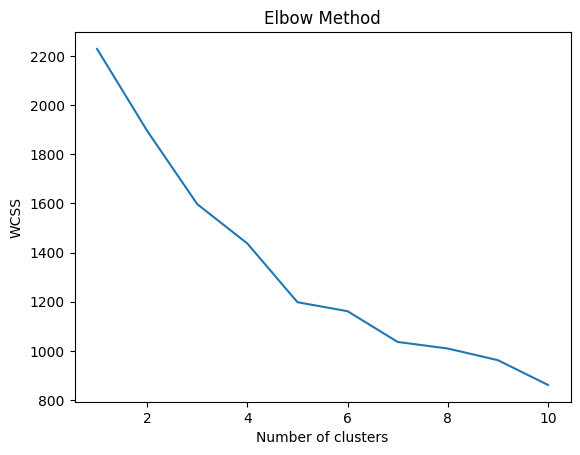

In [2371]:
from sklearn.cluster import KMeans


wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [2372]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(df)

#added clusters to df
df['Cluster'] = kmeans.labels_

In [2373]:
from sklearn import metrics

# Evaluate clustering performance
silhouette_avg_kmeans = metrics.silhouette_score(df, kmeans_clusters)
davies_bouldin_kmeans = metrics.davies_bouldin_score(df, kmeans_clusters)

print("Silhouette Score (K Means):", silhouette_avg_kmeans)
print("Davies-Bouldin Index (K Means):", davies_bouldin_kmeans)

Silhouette Score (K Means): 0.3893156359466838
Davies-Bouldin Index (K Means): 1.1540087205862741


In [2374]:
# Grouping by clusters and calculating mean for each feature
cluster_summary = df.groupby('Cluster').mean()
print(cluster_summary)

              age    gender  bloodpressure  diabetic  children    smoker  \
Cluster                                                                    
0        0.897693  1.000000       0.210069  0.536458  0.202083  0.828125   
1        0.459683  0.245000       0.249722  0.748333  0.222667  0.780000   
2        0.401221  0.430769       0.190940  0.471795  0.221538  0.779487   
3        0.320635  0.692754       0.253913  0.147826  0.224348  0.808696   

           region  Log_Claims  agegroup_Middle-Aged  agegroup_Senior  \
Cluster                                                                
0        0.517865    0.518480              0.000000              1.0   
1        0.528267    0.530245              0.805000              0.0   
2        0.431641    0.464008              0.630769              0.0   
3        0.525768    0.519444              0.400000              0.0   

         bmigroup_Normal  bmigroup_Overweight  
Cluster                                        
0             

C:\Users\KAUST\AppData\Local\Temp\ipykernel_11104\2781122656.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('viridis', len(np.unique(kmeans_clusters)))


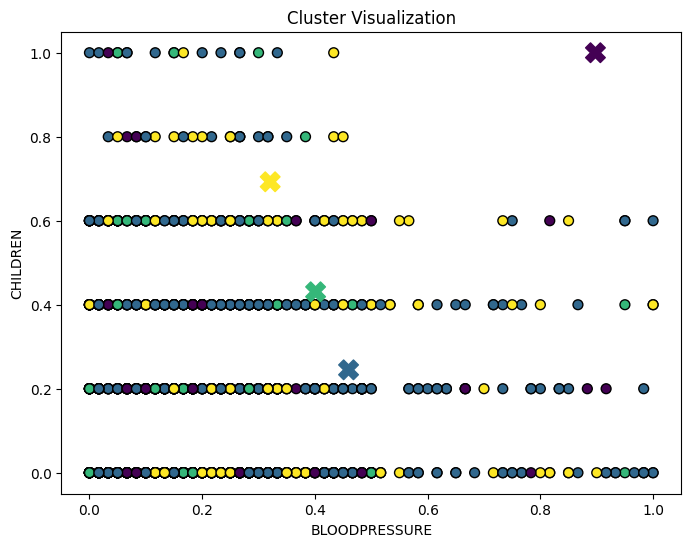

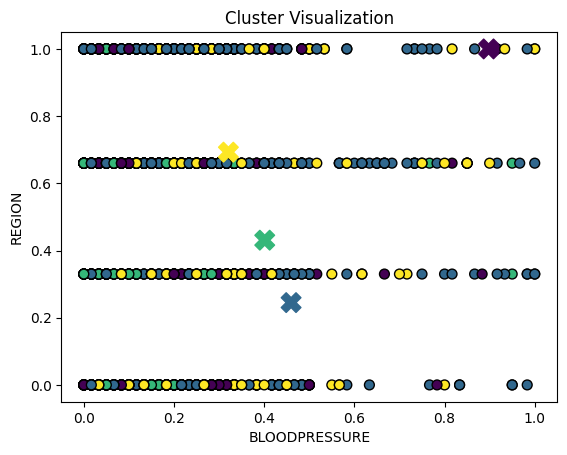

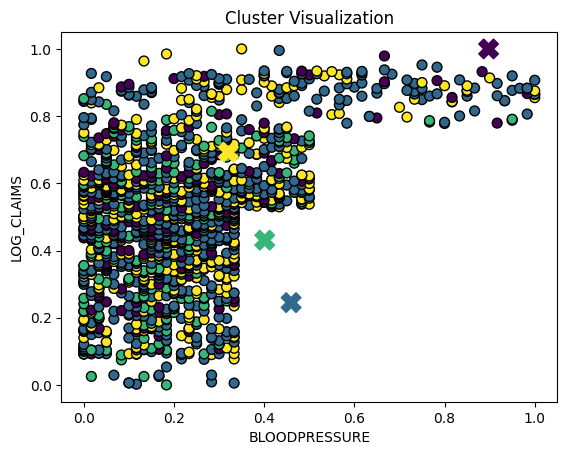

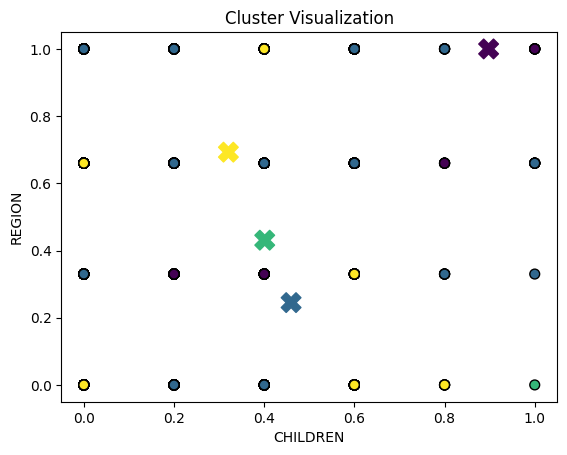

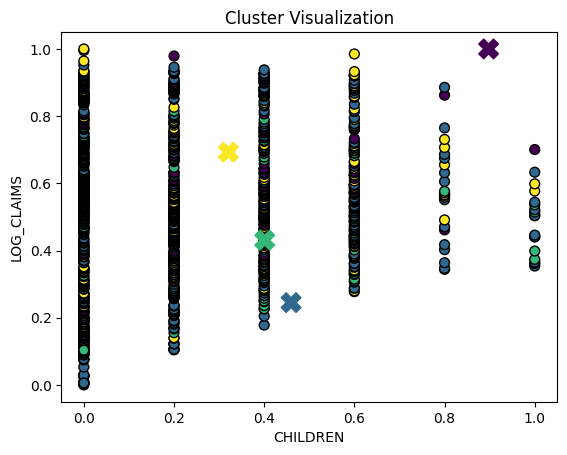

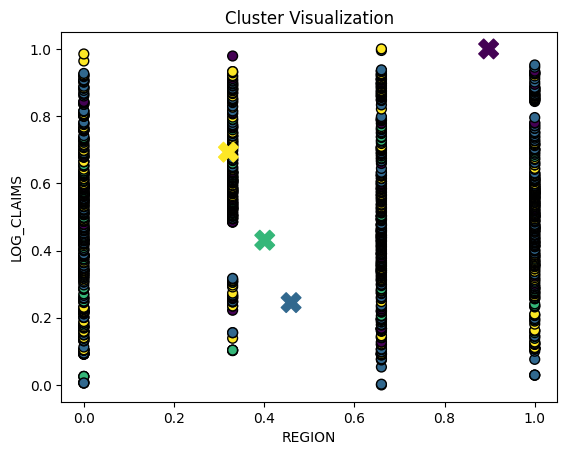

In [2376]:
# Visualize clusters
plt.figure(figsize=(8, 6))

# 'age', 'bmi', 'bloodpressure', 'children', 'region', 'Log_Claims'

graphLabels = [
    ['bloodpressure', 'children'],
    ['bloodpressure', 'region'],
    ['bloodpressure', 'Log_Claims'],
    ['children', 'region'],
    ['children', 'Log_Claims'],
    ['region', 'Log_Claims'],
]

centers = kmeans.cluster_centers_

colormap = plt.cm.get_cmap('viridis', len(np.unique(kmeans_clusters)))
centroidColor = [colormap(i) for i in range(0, n_clusters)]

for i in range(len(graphLabels)):
    # plt.scatter(df[x], df[y], c=kmeans_clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.scatter(df[graphLabels[i][0]], df[graphLabels[i][1]], c=kmeans_clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.xlabel(graphLabels[i][0].upper())
    plt.ylabel(graphLabels[i][1].upper())
    plt.title('Cluster Visualization')
    plt.scatter(centers[:, 0], centers[:, 1], c=centroidColor, marker='X', s=200, label='Centroids')
    plt.show()

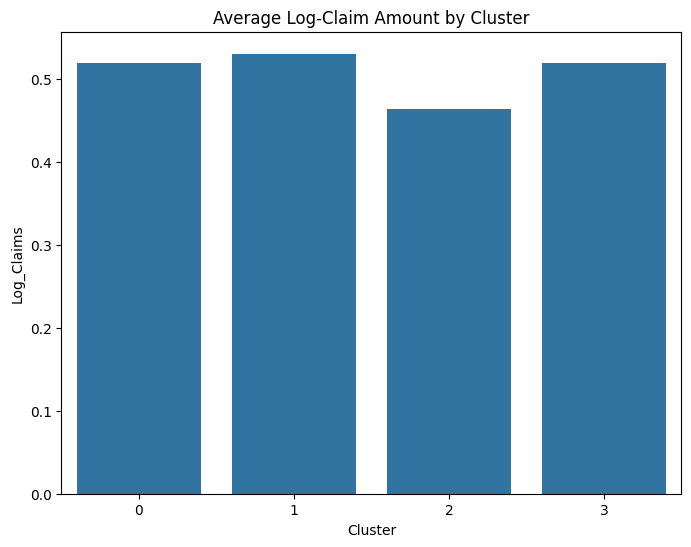

In [2377]:
# Bar plot for average log-claim by cluster
cluster_avg_claim = df.groupby('Cluster')['Log_Claims'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Log_Claims', data=cluster_avg_claim)
plt.title('Average Log-Claim Amount by Cluster')
plt.show()